拡散モデル（DDPM）でCIFER-10をベースにした画像生成をしてみる
===================

**概要**

書籍[「コンピュータビジョン最前線 Summer 2023」](https://www.amazon.co.jp/dp/B0C6JW6T6B/)の「イマドキノ拡散モデル（石井雅人様）」の解説をもとに、基本的な拡散モデル（DDPM: Denoising Diffusion Probabilistic Models）を実装します。

訓練データはCIFER-10とし、最後に「船」のクラスだけの画像セットにファインチューニングをして、船の画像を生成します。

ノイズから画像を生成される様子をGifで保存します。

<br>

**実装者**：小川 雄太郎

**実装日**：2023年07月02日

**実行環境**：Google Colab




---
（参考文献）

- 書籍：[「コンピュータビジョン最前線 Summer 2023」](https://www.amazon.co.jp/dp/B0C6JW6T6B/)
- 実装のベース参考：https://dataflowr.github.io/website/modules/18a-diffusion/

---


## [0] 初期化とimportを実施

### [0-1] GPU情報の確認


Google ColabのA100を使用しています（T4でも良いですが、時間がかかります）

In [1]:
!nvidia-smi

Sun Jul  2 11:12:11 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0    44W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### [0-2] importの実施


In [2]:
# 標準
import os
import sys
import random
import numpy as np
from tqdm.notebook import tqdm

# 描画系
from IPython import display
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import rc
from ipywidgets import interact
%matplotlib inline

# torch関連
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader

import torchvision
from torchvision import transforms
from torchvision.datasets import MNIST


### [0-3] 乱数seedの初期化



In [3]:
# 乱数シードの初期化
seed_val = 1234

print("使用するseedの値: ", str(seed_val))
os.environ['PYTHONHASHSEED'] = str(seed_val)
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val) # PyTorchはこちら参考 https://pytorch.org/docs/stable/notes/randomness.html
torch.cuda.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
# GPU高速化
torch.backends.cudnn.benchmark = True

# GPUの再現性まで確保したい場合（ただし、計算速度が低下してしまいます）
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False


使用するseedの値:  1234


### [0-4] 環境情報の確認 & GPUT情報を変数deviceに格納する



In [4]:
# -----------------------------
# 環境情報の確認関数を定義
# -----------------------------
def print_program_info():
    print("Pythonのバージョン: ", sys.version)
    print("---------")
    print("PyTorchのバージョン: ",
    torch.__version__)
    print("GPUの枚数: ", torch.cuda.device_count())
    global device  # 変数deviceは以降もプログラム本体で使用するのでglobal変数にしています
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("device: ", device)


# 確認を実行
print_program_info()

Pythonのバージョン:  3.10.12 (main, Jun  7 2023, 12:45:35) [GCC 9.4.0]
---------
PyTorchのバージョン:  2.0.1+cu118
GPUの枚数:  1
device:  cuda:0


## [1] CIFAR10のDatasetとDataLoaderを用意する


In [5]:
# CIFAR-10
# https://discuss.pytorch.org/t/unknown-error-when-using-albumentations-with-cifar10-dataset-torchvision/136598
# ================================
# 【CIFAR-10の10クラス】
# classes = ('airplane', 'car', 'bird', 'cat', 'deer',
#              'dog', 'frog', 'horse', 'ship', 'truck')
#
# 【平均と標準偏差（stdには2パターンが存在している？）】
# img_mean = (0.4914, 0.4822, 0.4465)
# img_std = (0.2023, 0.1994, 0.2010)  # (0.2471, 0.2435, 0.2616)
# ================================


# 画像変換を定義
transform_simple = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
    ])

# datasetとdataloaderのインスタンス化
dataset = torchvision.datasets.CIFAR10(root='./data/', train=True, transform=transform_simple, download=True)
dataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=512, shuffle=True, drop_last=True, pin_memory=True, num_workers=os.cpu_count())


100%|██████████| 170498071/170498071 [00:03<00:00, 43674632.22it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data/


In [6]:
def show_images(images, title=""):
    """画像を描画する（2x10個）の可視化関数を定義"""
    # [1] 画像をNumpyに変換、チャネル順の整理
    images = [im.permute(1,2,0).numpy() for im in images]

    # [2] 図の設定。縦横の数設定
    fig = plt.figure(figsize=(10, 2))
    rows, cols = 2, 10

    # [3] sub-plotsする
    idx = 0
    for r in range(rows):
        for c in range(cols):
            fig.add_subplot(rows, cols, idx + 1)
            plt.imshow(images[idx])
            plt.axis('off')  # 縦軸、横軸を非表示にする
            idx += 1

    # [4] 図のタイトルを表記し、描画
    fig.suptitle(title, fontsize=12)
    plt.show()


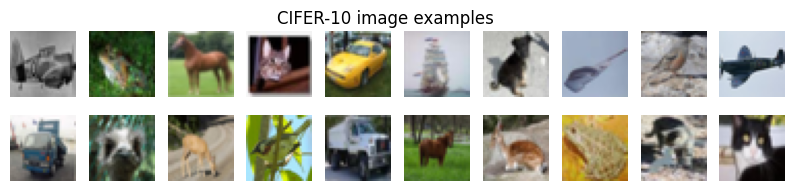

In [7]:
# 1つ目のバッチから画像を20個取得して描画する

batch_iterator = iter(dataloader) # イテレータに変換
batch, labels = next(batch_iterator)  # 1番目のミニバッチを取り出す
show_images(images=batch[:20], title="CIFER-10 image examples")


In [8]:
# shapeの確認
print(batch.shape)
print(labels.shape)

torch.Size([512, 3, 32, 32])
torch.Size([512])


## [2] 拡散モデル（DDPM：Denoising Diffusion Probabilistic Model）を定義


以下、数式番号などは、書籍[「コンピュータビジョン最前線 Summer 2023」](https://www.amazon.co.jp/dp/B0C6JW6T6B/)の

「イマドキノ拡散モデル（石井雅人様）」の解説に沿います。

---

まず、時刻t-1から時刻tへノイズが加えられて拡散していく過程は以下の式で表されます。


$$
    x_t = \sqrt{1-\beta_t} \, x_{t-1} + \sqrt{\beta_t} \, \epsilon_{t} \tag{1}
$$

$ \beta_t $ は時間変化し、徐々に大きくなります（強く拡散されます）


$ \alpha_t = 1-\beta_t $ 、$ \bar{\alpha_t} = \prod_{i=1}^{t}\alpha_t$ と変数を定義します。

In [9]:
class DDPM(nn.Module):
    def __init__(self, network, num_timesteps=1000, beta_start=0.0001, beta_end=0.02, device=device):
        super(DDPM, self).__init__()

        self.device = device
        self.network = network
        self.num_timesteps = num_timesteps  # 1000

        self.betas = torch.linspace(beta_start, beta_end, num_timesteps, dtype=torch.float32).to(device)  # betaの時間変化
        self.alphas = 1.0 - self.betas                                          # 各時刻のalpha
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)                # alphaをかけ算していった結果
        self.sqrt_alphas_cumprod = self.alphas_cumprod ** 0.5                   # add_noiseで使用
        self.sqrt_one_minus_alphas_cumprod = (1 - self.alphas_cumprod) ** 0.5   # add_noise と stepで使用


    def add_noise(self, x_start, x_noise, timesteps):
        """解説の式(3)に該当します。
         とある、t=timestepのときのx_tを求めます"""

        s1 = self.sqrt_alphas_cumprod[timesteps]            # bs
        s2 = self.sqrt_one_minus_alphas_cumprod[timesteps]  # bs
        s1 = s1.reshape(-1,1,1,1)                           # (bs, 1, 1, 1) for broadcasting
        s2 = s2.reshape(-1,1,1,1)                           # (bs, 1, 1, 1)
        return s1 * x_start + s2 * x_noise


    def reverse(self, x, t):
        """self.network（後ほど実装するU-Net）で、加えられたであろうノイズ（epsilon_theta(x_t, t)）を推論します
        推論したノイズは、解析の式(16)で使用されます"""
        return self.network(x, t)


    def step(self, model_output, timestep, sample):
        """
        解析の式(16)に基づき、逆拡散仮定に基づくデータ生成を行います。
        なぜこの方法で良いかは、書籍の解説が非常に分かりやすく丁寧なので、是非そちらをご覧ください。
        現在(t=timestep)での画像「sample = x_t」、から、1step後の画像を生成します
        """

        # [1] 解説の式(16)でmu_theta(x_t,t)を求める
        t = timestep
        coef_epsilon = self.betas/self.sqrt_one_minus_alphas_cumprod
        coef_eps_t = coef_epsilon[t].reshape(-1,1,1,1)
        coef_first = 1.0/((1.0-self.betas) ** 0.5)
        coef_first_t = coef_first[t].reshape(-1,1,1,1)
        pred_prev_sample = coef_first_t*(sample-coef_eps_t*model_output)

        # [2] 求めたノイズの平均値と元々決めていた分散で次の画像を生成します
        variance = 0
        if t > 0:  # t=0の最初以外
            noise = torch.randn_like(model_output).to(self.device)  # 正規分布のノイズを用意
            variance = ((self.betas[t] ** 0.5) * noise)  #

        pred_prev_sample = pred_prev_sample + variance  #

        return pred_prev_sample


## [3] ノイズ「$ε_θ(x_t, t)$」を推定するためのU-Netを定義


このニューラルネットワークは本当は何でも良いです。

ただしこのネットワークの性能が生成できる画像の質に影響する（はずです）

今回はSelf-Attentionなども何もない、シンプルなU-Netを構築してみます。



### [3-1] U-Netの途中で使用するブロックを定義

In [10]:
class double_conv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)


In [11]:
class down_layer(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.pool = nn.MaxPool2d(2, stride=2, padding=0)
        self.conv = double_conv(in_ch, out_ch)  # 上で定義した「in_ch->からout_ch」に変換するConv2dx2を使用

    def forward(self, x):
        return self.conv(self.pool(x))


In [12]:
class up(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.up_scale = nn.ConvTranspose2d(in_ch, out_ch, 2, stride=2)  # 画像サイズが2倍になる

    def forward(self, x1, x2): # x1 (bs,out_ch,w1,h1) x2 (bs,in_ch,w2,h2)
        # x2を2倍にする
        x2 = self.up_scale(x2) # (bs,out_ch,2*w2,2*h2)

        # x1とx2のサイズをx1にpaddingで合わせて、1つのテンソルにcatする
        diffY = x1.size()[2] - x2.size()[2]
        diffX = x1.size()[3] - x2.size()[3]

        x2 = F.pad(x2, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])  # (bs,out_ch,w1,h1)

        x = torch.cat([x2, x1], dim=1) # (bs,2*out_ch,w1,h1)
        return x


In [13]:
class up_layer(nn.Module):
    def __init__(self, in_ch, out_ch): # !! 2*out_ch = in_ch !!
        super().__init__()
        self.up = up(in_ch, out_ch)
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2): # x1 (bs,out_ch,w1,h1) x2 (bs,in_ch,w2,h2)
        a = self.up(x1, x2) # (bs,2*out_ch,w1,h1)
        x = self.conv(a) # (bs,out_ch,w1,h1) because 2*out_ch = in_ch。
        # 上で定義したin_ch->からout_chに変換するConv2dx2を使用
        return x


### [3-2] sinusoidal (正弦関数の) 位置埋め込みの定義

ネットワークに対して、推論したいノイズに関するtime step、すなわち拡散過程の何時刻目（何週目）のtにいるのかが分かるように、データに時刻情報を埋め込みます

（LLM系の文字の順番の位置埋め込みと処理はほぼ同じです。今回であれば、1000回拡散過程を経るうちの何回目なのかを情報としてネットワークに渡したいです）



In [14]:
def sinusoidal_embedding(n, d):
    embedding = torch.tensor([[i / 10_000 ** (2 * j / d) for j in range(d)] for i in range(n)])
    sin_mask = torch.arange(0, n, 2)

    embedding[sin_mask] = torch.sin(embedding[sin_mask])
    embedding[1 - sin_mask] = torch.cos(embedding[sin_mask])

    return embedding  # torch.Size([n, d])


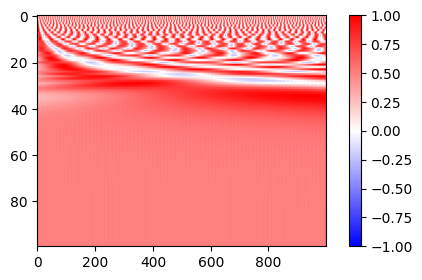

In [15]:
# 可視化して確認しておきます（nは拡散過程が1000time step、dは時刻を表す情報をd次元で作成する、という意味です）
n, d =1000, 100
time_embedding = sinusoidal_embedding(n, d)
data = time_embedding.numpy()

fig = plt.figure(figsize=(6, 3))
plt.imshow(data.T, cmap="bwr",aspect=8)
plt.colorbar()
plt.show()


上記の「sinusoidal (正弦関数の) 位置埋め込み」の結果について、縦方向に値を100個見れば、時刻（time step）が一意に定まります。


のちのほどのU-Netの中では、実際にはこの埋め込みでの100次元の変数を各深さのch数に合わせた次元にLinearx2で加工します。

### [3-3] U-Netを定義

In [16]:
class UNet(nn.Module):
    def __init__(self, in_channels=3, n_steps=1000, time_emb_dim=100):
        super().__init__()

        # [1] U-Netの前半部分
        self.conv1 = double_conv(in_channels, 64)  # in_channels=3 -> out_ch=64へ、conv2d x 2回
        self.down1 = down_layer(64, 128)           # maxpoolingで画像サイズが32->16になり、double_convでchが 64->128
        self.down2 = down_layer(128, 256)          # maxpoolingで画像サイズが16->08になり、double_convでchが128->256
        self.down3 = down_layer(256, 512)          # maxpoolingで画像サイズが08->04になり、double_convでchが256->512
        self.down4 = down_layer(512, 1024)         # maxpoolingで画像サイズが04->02になり、double_convでchが512->1024

        # [2] U-Netの後半部分
        self.up1 = up_layer(1024, 512)             # upで画像サイズが02->04になり、double_convでchが1024->512
        self.up2 = up_layer(512, 256)              # upで画像サイズが04->08になり、double_convでchが 512->256
        self.up3 = up_layer(256, 128)              # upで画像サイズが08->16になり、double_convでchが 256->128
        self.up4 = up_layer(128, 64)               # upで画像サイズが16->32になり、double_convでchが 128-> 64

        # [3] 最後
        self.last_conv = nn.Conv2d(64, in_channels, 1)  # in_ch=64、out_ch=3のkerne_size=1のpointiwiseConv

        # [4] sinusoidal (正弦関数の) 位置埋め込み層
        self.time_embed = nn.Embedding(n_steps, time_emb_dim)  # (1_000, 100)
        self.time_embed.weight.data = sinusoidal_embedding(n_steps, time_emb_dim)  # (1_000, 100)
        self.time_embed.requires_grad_(False)  # 勾配計算はしない。更新しない

        # [5] 位置埋め込みのd次元ベクトルを各チャネルの次元数のベクトルにLinearx2で加工するモジュール
        self.te1 = self._make_te(time_emb_dim, in_channels)   # time_emb_dim=100 -> dim_out=3のブロック(Linear x 2)
        self.te2 = self._make_te(time_emb_dim, 64)            # time_emb_dim=100 -> dim_out=64のブロック(Linear x 2)
        self.te3 = self._make_te(time_emb_dim, 128)           # time_emb_dim=100 -> dim_out=128のブロック(Linear x 2)
        self.te4 = self._make_te(time_emb_dim, 256)           # time_emb_dim=100 -> dim_out=256のブロック(Linear x 2)
        self.te5 = self._make_te(time_emb_dim, 512)           # time_emb_dim=100 -> dim_out=512のブロック(Linear x 2)
        self.te1_up = self._make_te(time_emb_dim, 1024)       # time_emb_dim=100 -> dim_out=1024のブロック(Linear x 2)
        self.te2_up = self._make_te(time_emb_dim, 512)        # time_emb_dim=100 -> dim_out=512のブロック(Linear x 2)
        self.te3_up = self._make_te(time_emb_dim, 256)        # time_emb_dim=100 -> dim_out=256のブロック(Linear x 2)
        self.te4_up = self._make_te(time_emb_dim, 128)        # time_emb_dim=100 -> dim_out=128のブロック(Linear x 2)


    def _make_te(self, dim_in, dim_out):
        """
        位置埋め込みのd次元ベクトルを各チャネルの次元数のベクトルにLinearx2で加工するモジュール
        init関数内のself._make_te()で使用されている、Linear->SiLU->Linear
        # SiLU: https://pytorch.org/docs/stable/generated/torch.nn.SiLU.htm
        """

        return nn.Sequential(nn.Linear(dim_in, dim_out), nn.SiLU(), nn.Linear(dim_out, dim_out))


    def forward(self, x , t):
        """xは[bs,in_channels,w,d]です。
        tはミニバッチの各データにおいて、どの時間（拡散過程の1-1000のどのt）なのかを指定します"""

        bs = x.shape[0]  # 512
        t = self.time_embed(t)  # torch.Size([bs, 100]) = (bs, time_emb_dim)

        # [1] U-Netの前半のforward
        x1 = self.conv1(x+self.te1(t).reshape(bs, -1, 1, 1))             # (bs,64,w,d)
        x2 = self.down1(x1+self.te2(t).reshape(bs, -1, 1, 1))            # (bs,128,w/2,d/2)
        x3 = self.down2(x2+self.te3(t).reshape(bs, -1, 1, 1))            # (bs,256,w/4,d/4)
        x4 = self.down3(x3+self.te4(t).reshape(bs, -1, 1, 1))            # (bs,512,w/8,h/8)
        x5 = self.down4(x4+self.te5(t).reshape(bs, -1, 1, 1))            # (bs,1024,w/16,h/16)

        # [2] U-Netの後半のforward
        x1_up = self.up1(x4, x5+self.te1_up(t).reshape(bs, -1, 1, 1))    # (bs,512,w/8,h/8)
        x2_up = self.up2(x3, x1_up+self.te2_up(t).reshape(bs, -1, 1, 1)) # (bs,256,w/4,h/4)
        x3_up = self.up3(x2, x2_up+self.te3_up(t).reshape(bs, -1, 1, 1)) # (bs,128,w/2,h/2)
        x4_up = self.up4(x1, x3_up+self.te4_up(t).reshape(bs, -1, 1, 1)) # (bs,64,w,h)

        # [3] ラスト
        output = self.last_conv(x4_up) # (bs,in_channels,w,h)

        return output


### [3-4] U-Netの動作を確認したい場合は以下をご使用ください

In [17]:
# bs = 5
# x = torch.randn(bs,3,32,32)
# n_steps=1000
# timesteps = torch.randint(0, n_steps, (bs,)).long()
# unet = UNet()


In [18]:
# print(timesteps.shape)
# print(timesteps)
# print(x.shape)


In [19]:
# y = unet(x,timesteps)  # x=torch.Size([5, 3, 32, 32]), torch.Size([5])
# print(y.shape)

### [3-5] 訓練関数を定義する


In [20]:
def training_loop(model, dataloader, optimizer, num_epochs, num_timesteps, device=device):
    """訓練関数"""

    global_step = 0
    losses = []

    for epoch in range(num_epochs):
        model.train()
        progress_bar = tqdm(total=len(dataloader))
        progress_bar.set_description(f"Epoch {epoch}")

        for step, (batch, label) in enumerate(dataloader):
            batch = batch.to(device)

            # [1] ノイズと適当なtimestepsを生成
            noise = torch.randn(batch.shape).to(device)  # 画像のshape [Bs, 3, 32, 32]と同じノイズ（正規分布に従う）を作成
            timesteps = torch.randint(0, num_timesteps, (batch.shape[0],)).long().to(device)  # バッチサイズ分、0-999のいずれかの整数値の値を作成

            # [2] 上記の適当な時刻timestepsにおける画像に、これまた上記で作成したノイズを加えた画像を作成
            noisy = model.add_noise(batch, noise, timesteps)

            # [3] ノイズが加えられた画像から、各時刻において、加えられたノイズをU-Netを使用して推論する
            noise_pred = model.reverse(noisy, timesteps)  # ここでU-netが使用されています。modelはclass DDPMです。関数reverseはreturn self.network(x, t)

            # [4] 加えたノイズと推論したノイズとのMSE誤差を求めてBackPropする
            # 【補注】なぜこのノイズを推定して、誤差関数MSEでBackPropで良いのかは解説の式(14)に相当します。
            # 解説の式(14)が出てくる流れを読んでみてください。
            loss = F.mse_loss(noise_pred, noise)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # [5] 後処理
            progress_bar.update(1)  # pbarを1つ進める
            logs = {"loss": loss.detach().item(), "step": global_step}
            losses.append(loss.detach().item())
            progress_bar.set_postfix(**logs)  # pbarにlossとstepの情報を掲載
            global_step += 1

        progress_bar.close()

### [3-8] 訓練を実行する


In [21]:
# ハイパラ設定
learning_rate = 1e-3
num_timesteps = 1000

In [22]:
# U-Netのインスタンスを作成
unet = UNet(in_channels=3)
unet.to(device)

# DDPMのインスタンスを作成
model = DDPM(unet, num_timesteps, beta_start=0.0001, beta_end=0.02, device=device)
model.train()

# Optimizerを設定
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


（以下、model内に含まれている訓練パラメータを表示して確認したい場合）

In [23]:
# for n, p in model.named_parameters():
#     print(n, p.shape)

（以下、訓練済みモデルのパラメータをロードしたい場合）

In [24]:
# # 訓練済みのモデルを使用する場合
# unet.load_state_dict(torch.load('/content/unet_230701.pth'))


In [25]:
# 訓練開始
# ============================
# 【1 epochにかかる時間】
# GPUがT4（Google Colabの標準GPU）: 約45秒
# GPUがA100の場合: 約8秒


num_epochs = 50  # 15
training_loop(model, dataloader, optimizer, num_epochs, num_timesteps, device=device)


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

In [26]:
# # モデルの重みを保存する場合
# torch.save(unet.state_dict(), '/content/unet_230701.pth')


## [4] 訓練結果を確認。画像を生成し可視化する


### [4-1] 適当なノイズから画像を生成


In [27]:
def generate_image(ddpm, sample_size=20, channel=3, size=32):
    """正規分布に従うノイズから、画像を生成する関数を定義します"""

    frames = []      # 最終画像を格納するリスト
    frames_mid = []  # 拡散過程800time step目の画像を格納するリスト
    ddpm.eval()

    with torch.no_grad():
        # [1] 逆順にtime_stepを用意する
        timesteps = list(range(ddpm.num_timesteps))[::-1]  # [1000, 999, ・・・, 0]

        # [2] 初期値のノイズ状態。ここからreverseしていって画像にする
        sample = torch.randn(sample_size, channel, size, size).to(device)

        # [3] 画像を生成していく
        for i, t in enumerate(tqdm(timesteps)):
            # [3-0] サンプル数分、時間stepのテンソルを拡張する
            time_tensor = (torch.ones(sample_size,1) * t).long().to(device)

            # [3-1] U-Netでその時刻に加えられたであろうノイズ ε_thetaを推定する
            residual = ddpm.reverse(sample, time_tensor)

            # [3-2] 推定したノイズ「residual」、現在の時刻（time_tensor[0]）、現在の画像（sample）からひとつ前のtime stepのより綺麗な画像を推論
            sample = ddpm.step(residual, time_tensor[0], sample)  # time_tensor[0]はtensor([999])からtensor([998]と小さくなっていく

            # [3-3] トータル1000回の拡散過程（逆拡散過程）のうち、800回目の画像を保存（Mid result (t=800)）
            if t==800:
                for i in range(sample_size):
                    frames_mid.append(torch.clamp(sample[i], min=0, max=1.0).detach().cpu())

        # [3-4] 最終画像をリストに加える
        for i in range(sample_size):
            frames.append(torch.clamp(sample[i], min=0, max=1.0).detach().cpu())

    return frames, frames_mid

In [28]:
# 標準正規分布に従うランダムノイズから画像を生成する
generated, generated_mid = generate_image(ddpm=model, sample_size=20, channel=3, size=32)


  0%|          | 0/1000 [00:00<?, ?it/s]

### [4-2] 途中結果と最終結果の表示


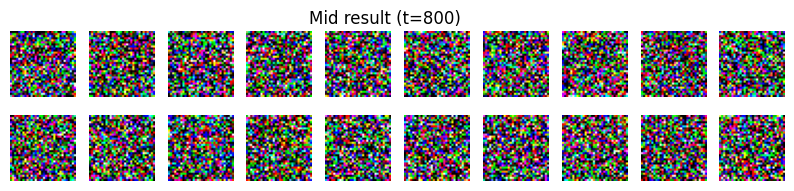

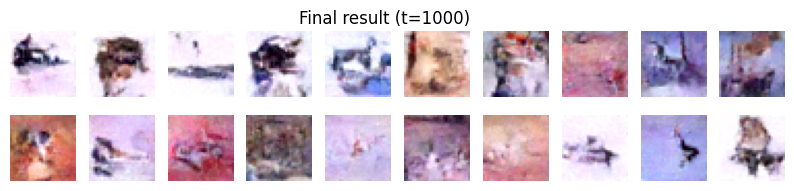

In [29]:
# 上で定義したshow_imagesを使用する

show_images(generated_mid, "Mid result (t=800)")

show_images(generated, "Final result (t=1000)")

逆拡散過程のtime step=800ではほぼノイズですが、最終的には、なにやら画像っぽいのが見えています

## [5] 特定のクラスについて、ファインチューニングする


画像生成といえば、文章で条件付けて、その文章内容の画像を生成したいですが、今回のシンプルなものでは、それは難しいです。

こうした応用については、解説のp.20の「3 拡散モデルを使った条件付き生成」にて、非常に丁寧に紹介・解説されています

今回は、CIFER-10の「船（ship）」のクラスだけのDataLoaderを作成し、それで上記の拡散モデルをさらにファインチューニングし、船の画像を生成するという荒業にします。

---

CIFER-10の特定クラスだけのDataset、DataLoaderを作成します

In [30]:
from torch.utils.data import Subset

def make_dataloader(dataset, class_name ='airplane'):
    s_indices = []
    s_idx = dataset.class_to_idx[class_name]
    for i in range(len(dataset)):
        current_class = dataset[i][1]
        if current_class == s_idx:
            s_indices.append(i)
    s_dataset = Subset(dataset, s_indices)
    dataloader = torch.utils.data.DataLoader(dataset=s_dataset, batch_size=512, shuffle=True, drop_last=True, pin_memory=True, num_workers=os.cpu_count() )
    return dataloader


In [31]:
# shipの画像だけのDataLoaerを作成
s_dataloader = make_dataloader(dataset,  class_name ='ship')


In [32]:
# ship画像用のU-netとDDPMを作成
import copy

s_unet = copy.deepcopy(unet)  # 訓練したU-Netをコピーして、ファインチューニングに使用します
s_model = DDPM(s_unet, num_timesteps, beta_start=0.0001, beta_end=0.02, device=device)

s_model.train()
optimizer = torch.optim.Adam(s_model.parameters(), lr=learning_rate)

# 【注釈】さきほど訓練したモデルに上書きで訓練しないでコピーしているのは、別のクラスの画像を生成したいときに、ベースを残しとくためです（今回は船しか試していませんが）

In [33]:
# ファインチューニング開始
# ============================
# GPUがT4（Google Colabの標準GPU）の場合、1 epochは約4秒となります, A100だと1秒です

num_epochs = 15
training_loop(s_model, s_dataloader, optimizer, num_epochs, num_timesteps, device=device)


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

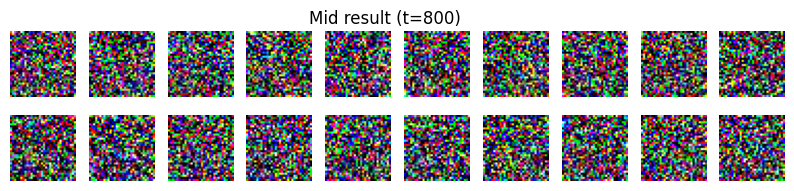

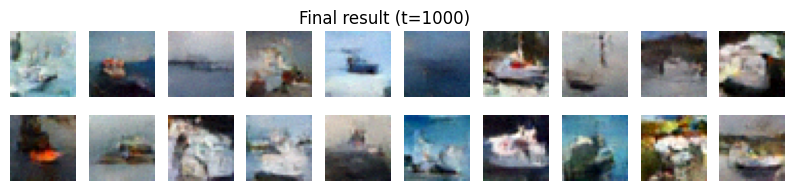

In [34]:
# 標準正規分布に従うランダムノイズから画像を生成する
generated, generated_mid = generate_image(ddpm=s_model, sample_size=20, channel=3, size=32)

#  途中結果と最終結果の表示
show_images(generated_mid, "Mid result (t=800)")
show_images(generated, "Final result (t=1000)")


## [6] 1サンプルについて、gifで変化していく様子を作成する


最後に、ガウシアンノイズな状態の画像から徐々に逆拡散過程を経て、綺麗？な画像が生成される様子をgifにします。

逆拡散過程は最後急激に画像が綺麗？になるので、以下ではgif用に抜き出す画像のtime stepが固定幅ではない点にご注意ください。

In [90]:
# 生成の関数を定義します

def generate_image_for_gif(ddpm, sample_size=1, channel=3, size=32):
    """Generate the image from the Gaussian noise"""

    # 結果を格納するリスト
    frames, frames_mid = [], []
    ddpm.eval()

    with torch.no_grad():
        # [1] 逆順にtime_stepを用意する
        timesteps = list(range(ddpm.num_timesteps))[::-1]  # [1000, 999, ・・・, 0]

        # [2] 初期値のノイズ状態。ここからreverseしていって画像にする
        sample = torch.randn(sample_size, channel, size, size).to(device)

        # [3] 画像を生成していく
        for i, t in enumerate(tqdm(timesteps)):
            # [3-0] サンプル数分、時間stepのテンソルを拡張する
            time_tensor = (torch.ones(sample_size,1) * t).long().to(device)

            # [3-1] U-Netでその時刻に加えられたであろうノイズを推定する
            residual = ddpm.reverse(sample, time_tensor)

            # [3-2] 推定したノイズ「residual」、現在の時刻time_tensor[0]、現在の画像「sample」からひとつ前の綺麗な画像を推論する
            sample = ddpm.step(residual, time_tensor[0], sample)  # time_tensor[0]はtensor([999])からtensor([998]と小さくなっていく

            # [3-3] 100回に1度画像を保存
            if t%100==0:
                for i in range(sample_size):
                    frames_mid.append(torch.clamp(sample[i], min=0, max=1.0).detach().cpu())  # torch.clampは画素の値が0から1の範囲に収まるようにするためにです
            elif t==50:  # 最後の50回目
                for i in range(sample_size):
                    frames_mid.append(torch.clamp(sample[i], min=0, max=1.0).detach().cpu())  # torch.clampは画素の値が0から1の範囲に収まるようにするためにです
            elif t<20:  # 最後の20回は毎回gif画像にする
                for i in range(sample_size):
                    frames_mid.append(torch.clamp(sample[i], min=0, max=1.0).detach().cpu())  # torch.clampは画素の値が0から1の範囲に収まるようにするためにです

        # [3-4] 最終画像をリストに加える（5回ほど）
        for i in range(sample_size):
            for _ in range(5):
                frames.append(torch.clamp(sample[i], min=0, max=1.0).detach().cpu())

    return frames, frames_mid


画像をランダムノイズから生成します。綺麗ないい感じの絵が生成できるまで、何度か（何度も？）試してみてください

  0%|          | 0/1000 [00:00<?, ?it/s]

30
torch.Size([3, 32, 32])


(-0.5, 31.5, 31.5, -0.5)

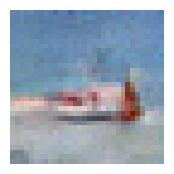

In [91]:
# 画像をランダムノイズから生成する
generated, generated_mid = generate_image_for_gif(ddpm=s_model, sample_size=1, channel=3, size=32)

# サイズと最終画像の確認
print(len(generated_mid))
print(generated_mid[0].shape)

plt.figure(figsize=(2, 2))
img = generated[0].permute(1,2,0).numpy()
plt.imshow(img)
plt.axis('off')  # 縦軸、横軸を非表示にする


In [92]:
# ------------------------------------------------------
# 可視化関数の定義 その1 （アニメーションで描画、実装の中身よく分からなくて良いです）
# ------------------------------------------------------
def show_animiation(view_data):
    rc("animation", html="jshtml")
    plt.figure(figsize=(2, 2))
    fig, ax = plt.subplots()
    imgs = view_data
    frames = [[ax.imshow(imgs[i], vmin=0.0, vmax=1.0, interpolation='none', cmap="gray")] for i in range(len(imgs))]
    plt.axis("off")
    ani = animation.ArtistAnimation(fig, frames)
    ani.save("ddpm_ship_230702.gif", writer="pillow")
    # ani.save('hogehoge.mp4', writer="ffmpeg")
    plt.close()
    return ani

In [93]:
# 可視化実行
generated_mid2 = torch.stack(generated_mid)
view_data_np = generated_mid2.permute([0,2,3,1]).numpy()
show_animiation(view_data_np)


<Figure size 200x200 with 0 Axes>

本プログラムは動作メインなので、ぜひなぜこれで画像が生成できるのかについて、その流れと各式の導出手順は参考書籍をご覧ください

とても丁寧で分かりやすい解説であり、私としては非常におススメです。

素晴らしい解説と書籍の出版をありがとうございました

<br>

参考：書籍[「コンピュータビジョン最前線 Summer 2023」](https://www.amazon.co.jp/dp/B0C6JW6T6B/)の「イマドキノ拡散モデル（石井雅人様）」の解説

# 以上